## Cường độ, thời gian kéo dài và tần suất của các trận mưa có đặc điểm gì?

### 1. Ý nghĩa của việc trả lời câu hỏi
- Hiểu bản chất mưa của khu vực: xác định mưa ngắn hay dài, nhẹ hay mạnh, xảy ra thường xuyên hay theo mùa → tạo nên đặc trưng khí hậu mưa

- Nhận diện quy luật mưa: từ đặc điểm mưa có thể xác định mùa nào mưa nhiều, mùa nào mưa ít, thời điểm mưa trong năm, và cách mưa phân bố theo thời gian

- Đánh giá sự ổn định và biến thiên khí hậu: nhận biết tính mùa vụ, các bất thường so với trung bình nhiều năm và xu thế biến đổi dài hạn của lượng mưa

### 2. Phân tích dữ liệu trả lời câu hỏi

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# load dữ liệu
df = pd.read_csv('../data/processed/weather_processed.csv')

# xử lý sơ bộ dữ liệu
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['location_id', 'datetime'])

In [190]:
# xác định những dòng ghi nhận thời điểm có mưa (>0.1mm)
RAIN_THRESHOLD = 0.1
df['is_raining'] = df['precipitation (mm)'] >= RAIN_THRESHOLD

# xác định các cơn mưa (gom những dòng có mưa liên tục vào 1 cơn mưa)
df['block_id'] = (
    (df['is_raining'] != df['is_raining'].shift()) |
    (df['location_id'] != df['location_id'].shift())
).cumsum()

# tạo df chứa thông tin các trận mưa
rain_events = df[df['is_raining']].groupby('block_id').agg(
    start_time=('datetime', 'min'),
    duration_hours=('datetime', 'count'),
    total_rainfall=('precipitation (mm)', 'sum'),
    max_intensity=('precipitation (mm)', 'max'),
    month=('month', 'first')
).reset_index()

# phân loại mức độ mưa
def categorize_rain(mm):
    if mm < 2.5: return 'Mưa nhỏ (<2.5mm)'
    elif mm < 10: return 'Mưa vừa (2.5-10mm)'
    elif mm < 50: return 'Mưa to (10-50mm)'
    else: return 'Mưa rất to (>50mm)'

rain_events['intensity_class'] = rain_events['max_intensity'].apply(categorize_rain)

In [191]:
# xét xem ngày nào là "ngày mưa" trong số những ngày có mưa
df['date'] = df['datetime'].dt.date
daily_rain = df.groupby(['location_id', 'date'])['precipitation (mm)'].sum().reset_index()
daily_rain['is_rainy_day'] = daily_rain['precipitation (mm)'] >= 1.0 # 1mm threshold for a "rainy day"

# chuẩn hoá lượng mưa trung bình của những "ngày mưa" (7 vị trí, 2 năm)
factor = 7 * 5
monthly_rainy_counts = daily_rain[daily_rain['is_rainy_day']].groupby(pd.to_datetime(daily_rain['date']).dt.month)['date'].count()
monthly_rainy_days_avg = monthly_rainy_counts / factor

# số lượng các trận mưa theo mức độ
freq_counts = rain_events['intensity_class'].value_counts()
# số lượng trận mưa to
heavy_rain_count = len(rain_events[rain_events['max_intensity'] >= 10])

# chu kỳ mưa: tổng thời gian theo dõi / tổng số cơn mưa (trung bình 1 trạm)
n_locations = df['location_id'].nunique()
total_hours = len(df) / n_locations  # tổng giờ gian theo dõi tại 1 trạm
total_events = len(rain_events) / n_locations # tổng số trận mưa tại 1 trạm
interval = total_hours / total_events if total_events > 0 else 0

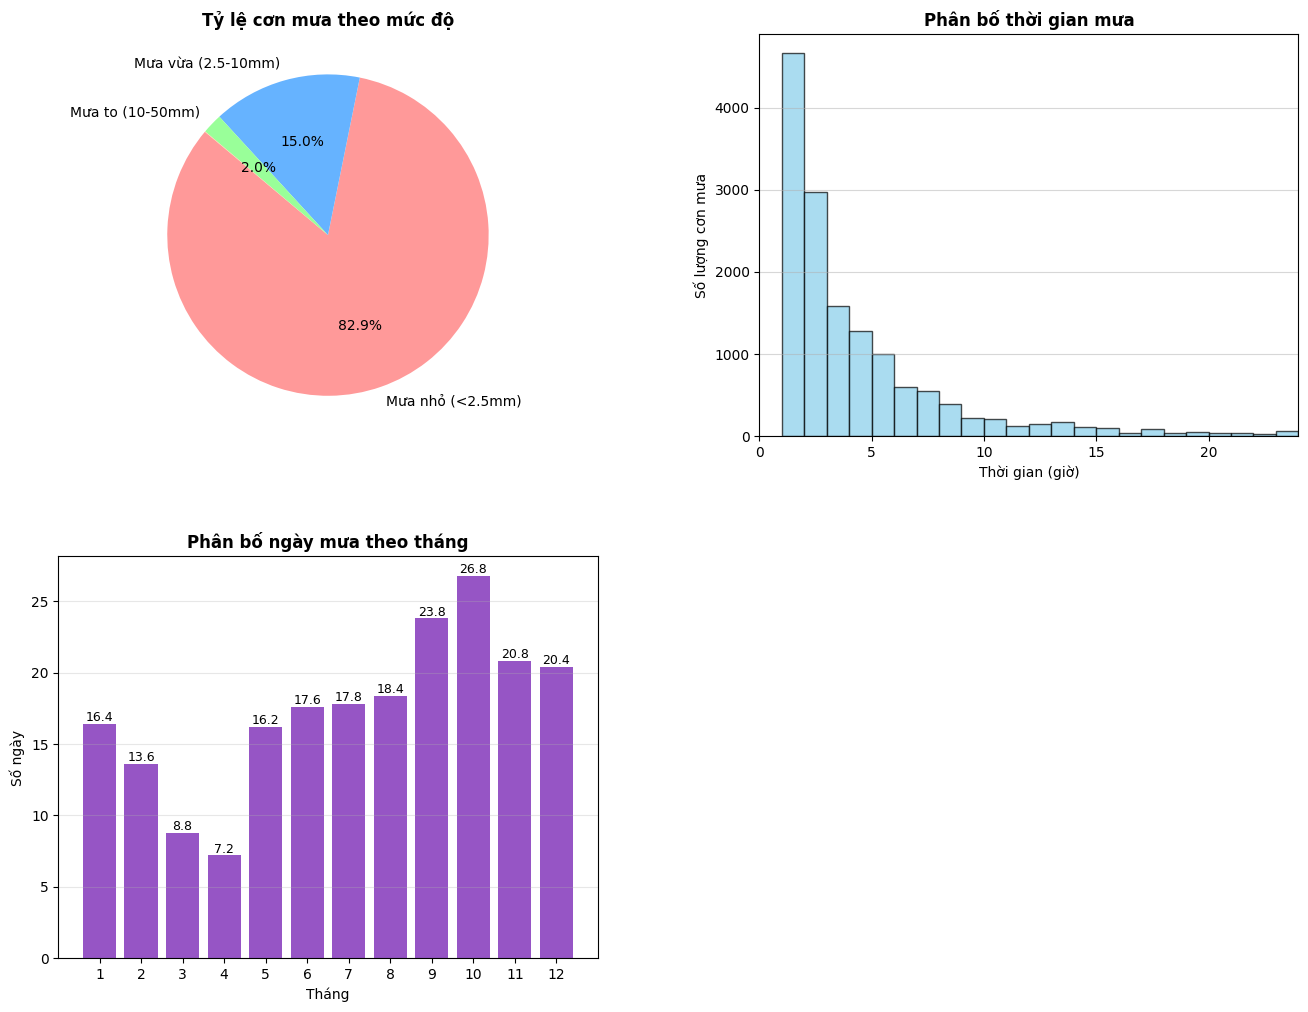

In [192]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Pie chart: biểu đồ tỉ lệ các cơn mưa theo mức độ
intensity_counts = rain_events['intensity_class'].value_counts()
colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = [
    '' if label == 'Mưa rất to (>50mm)' else label
    for label in intensity_counts.index
]
axes[0, 0].pie(intensity_counts, labels=labels, autopct=lambda pct: f'{pct:.1f}%' if pct > 0.5 else '', startangle=140, colors=colors_pie)
axes[0, 0].set_title('Tỷ lệ cơn mưa theo mức độ', fontsize=12, fontweight='bold')

# Histogram: phân bố thời gian kéo dài mỗi cơn mưa
axes[0, 1].hist(rain_events['duration_hours'], bins=range(1, 25), color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Phân bố thời gian mưa', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Thời gian (giờ)')
axes[0, 1].set_ylabel('Số lượng cơn mưa')
axes[0, 1].set_xlim(0, 24)
axes[0, 1].grid(axis='y', alpha=0.5)

# Bar chart: phân bố ngày mưa theo tháng
months = monthly_rainy_days_avg.index
values = monthly_rainy_days_avg.values
bars = axes[1, 0].bar(months, values, color='#6a0dad', alpha=0.7)
axes[1, 0].set_title('Phân bố ngày mưa theo tháng', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tháng')
axes[1, 0].set_ylabel('Số ngày')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)

fig.delaxes(axes[1, 1])
plt.show()

In [193]:
# chi tiết thống kê thời gian mưa
rain_events['duration_hours'].describe()

count    15176.000000
mean         6.034133
std         12.351242
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        200.000000
Name: duration_hours, dtype: float64

In [194]:
print(f"Tổng số trận mưa phân tích: {len(rain_events)}")
print(f"Thời gian mưa trung bình: {rain_events['duration_hours'].mean():.2f} giờ")
print(f"Cường độ lớn nhất ghi nhận: {rain_events['max_intensity'].max()} mm/h")

print(f"\nChu kỳ lặp lại trung bình: Cứ {interval:.1f} giờ có 1 trận mưa")
print(f"Tần suất mưa to (>10mm/h): {heavy_rain_count} trận (Chiếm {heavy_rain_count/len(rain_events)*100:.1f}%)")

very_heavy_rain_count = len(rain_events[rain_events['max_intensity'] >= 50])
print(f"Tần suất mưa rất to (>50mm/h): {very_heavy_rain_count} trận (Chiếm {very_heavy_rain_count/len(rain_events)*100:.5f}%)")

Tổng số trận mưa phân tích: 15176
Thời gian mưa trung bình: 6.03 giờ
Cường độ lớn nhất ghi nhận: 53.7 mm/h

Chu kỳ lặp lại trung bình: Cứ 19.8 giờ có 1 trận mưa
Tần suất mưa to (>10mm/h): 315 trận (Chiếm 2.1%)
Tần suất mưa rất to (>50mm/h): 7 trận (Chiếm 0.04613%)


#### NHẬN XÉT

#### a. Về cường độ mưa

- Từ pie chart, ta thấy phần lớn các trận mưa có cường độ trung bình thấp --> mưa chủ yếu là mưa nhỏ và vừa

- Cường độ mưa được ghi nhận cao nhất là 53.7 mm/h, là mức rất to

- Phân bố cường độ mưa:

  - Mưa nhỏ (<2.5mm/h): Chiếm đa số

  - Mưa vừa (2.5 - 10mm/h): Phổ biến trung bình

  - Mưa to (>10mm/h): Ít gặp hơn, có 315 trận, chiếm 2.1%

  - Mưa rất to (>50mm/h): Hiếm xuất hiện, chỉ ghi nhận 7 trận mưa trong toàn bộ dữ liệu

#### b. Về độ dài cơn mưa

- Thời gian trung bình: thời gian trận mưa ở các khu vực kéo dài trung bình khoảng 6.03 giờ.

- Phân bố:

  - 25% số trận mưa chỉ kéo dài 1 giờ

  - 50% số trận mưa kéo dài dưới 2 giờ

  - 75% số trận mưa kéo dài dưới 5 giờ


#### c. Về tần suất mưa

- Tổng số trận mưa: 15176 cơn mưa tách biệt trên 7 trạm đo được ghi nhận trong suốt giai đoạn 2021-2025

- Tần suất xuất hiện dày đặc (trên 20 ngày/tháng) vào các tháng 9-12

- Các tháng mùa khô (ví dụ như tháng 1, 2, 3) số lượng ngày mưa rất ít so với những tháng mùa mưa

#### Thống kê những đợt mưa lớn/kéo dài

In [ ]:
block_location_map = df[['block_id', 'location_id']].drop_duplicates()
rain_events_with_loc = rain_events.merge(block_location_map, on='block_id', how='left')

# lọc data của trạm đo có tổng lượng mưa lớn nhất
top_station = rain_events_with_loc.groupby('location_id')['total_rainfall'].sum().idxmax()
station_events = rain_events_with_loc[rain_events_with_loc['location_id'] == top_station].sort_values(by='start_time').copy()

# khoảng cách ngắt giữa các đợt mưa (wave)
GAP_THRESHOLD_HOURS = 24  

# tính đợt mưa
station_events['end_time'] = station_events['start_time'] + pd.to_timedelta(station_events['duration_hours'], unit='h')
station_events['prev_end'] = station_events['end_time'].shift(1)
station_events['gap_hours'] = (station_events['start_time'] - station_events['prev_end']).dt.total_seconds() / 3600
station_events['new_wave'] = (station_events['gap_hours'] > GAP_THRESHOLD_HOURS) | (station_events['gap_hours'].isna())
station_events['wave_id'] = station_events['new_wave'].cumsum()

# tổng hợp kết quả
final_waves = station_events.groupby('wave_id').agg(
    start_date=('start_time', 'min'),
    end_date=('end_time', 'max'),
    total_rainfall=('total_rainfall', 'sum'),
    max_intensity=('max_intensity', 'max'),
    duration_days=('start_time', lambda x: (x.max() - x.min()).days + 1)
).reset_index()

# in kết quả
print(f"\nCác đợt mưa lớn nhất tại trạm {top_station}:")
final_waves = final_waves.sort_values(by='total_rainfall', ascending=False)
pd.set_option('display.max_columns', None)
print(final_waves[['start_date', 'end_date', 'duration_days', 'total_rainfall', 'max_intensity']].head(10))


Các đợt mưa lớn nhất tại trạm 1:
             start_date            end_date  duration_days  total_rainfall  max_intensity
196 2025-10-04 05:00:00 2025-11-26 20:00:00             54          1186.8           23.9
111 2023-09-03 12:00:00 2023-11-10 06:00:00             68          1053.0           19.5
195 2025-08-06 06:00:00 2025-10-01 07:00:00             57           816.7           33.3
70  2022-09-14 05:00:00 2022-10-31 20:00:00             48           767.2           23.1
37  2021-10-03 04:00:00 2021-11-04 06:00:00             33           762.9           14.7
52  2022-03-27 05:00:00 2022-04-07 17:00:00             11           658.0           53.7
159 2024-10-26 02:00:00 2024-10-31 07:00:00              4           471.9           35.8
40  2021-12-07 18:00:00 2022-01-14 09:00:00             38           425.0           12.5
35  2021-08-25 04:00:00 2021-09-17 11:00:00             24           413.1            9.3
184 2025-06-03 07:00:00 2025-06-13 20:00:00             11        

### 3. Insights:
1. Mưa lũ trong mùa mưa ở Huế: 
    - 2025: Kỷ lục lịch sử với đợt mưa kéo dài 54 ngày (04/10–26/11), tổng lượng 1.186,8 mm, gây ngập lụt diện rộng.
        - Đợt mưa ngay trước đó cũng cực đoan không kém: kéo dài 57 ngày với tổng lượng 816.7mm
    - 2023: Mưa lớn từ tháng 9–11, tổng lượng 1.053 mm trong 68 ngày
    - 2022: Mưa lớn ở tháng 9-10, tổng mưa 767.2 mm trong 48 ngày
    - 2021: Mưa dầm kéo dài 33 ngày, tổng lượng mưa 762.9 mm

2. Mưa trái mùa (dị thường vì mưa ở Huế thường tập trung tháng 9-12):
    - 03/2022: từ 27/03–07/04, tổng 658 mm, tập trung 30/03–02/04 (555,7 mm, đỉnh 53,7 mm/h), gây ngập cục bộ giữa mùa khô
    - 06/2025: từ 03–13/06, tổng 365,3 mm, gây thiệt hại nặng cho vụ hè thu

3. Đặc điểm mưa lũ ở Huế:
    - Mưa muộn, tập trung vào cuối năm (tháng 9-12), các tháng đầu năm khô ráo
    - Mưa dầm, kéo dài hàng giờ, đa số là cường độ nhỏ-vừa, nếu kéo dài nhiều ngày, lượng mưa tích tụ lớn có thể khiến nước dâng cao và gây lũ lụt nghiêm trọng
    - Xu hướng mưa lũ có sự lặp lại ở năm 2022 và 2025: xu hướng "thiên tai kép", bên cạnh các đợt mưa lớn cuối năm thì cũng xuất hiện các trận mưa lớn dị thường ngay trong mùa khô, cho thấy thời tiết đang xảy ra biến động khó lường

Cần theo dõi tình hình mưa, đặc biệt các tháng chuyển mùa và khi mưa kéo dài, để đưa ra những phương án kịp thời phản ứng với những tình huống thời tiết cực đoan


Tham khảo: 
- https://tienphong.vn/mua-lon-hiem-gap-cuoi-nam-nhieu-noi-o-tt-hue-chim-trong-bien-nuoc-post1404594.tpo
- https://cand.com.vn/Xa-hoi/thua-thien-hue-oan-minh-hung-chiu-dot-mua-lu-trai-mua--i649058/
- https://media.chinhphu.vn/mua-tai-hue-vuot-muc-lich-su-cao-nhat-tung-ghi-nhan-o-viet-nam-102251027225025777.htm